<a href="https://colab.research.google.com/github/Snjkmr162/BLS_Chatbot_with_RL/blob/main/Chatbot_with_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs & Imports

In [171]:
!pip install requests pandas matplotlib scikit-learn transformers torch

In [172]:
import requests
import pandas as pd
import numpy as np
import pickle
import os
import random
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# BLS Data Fetching & Loading

In [173]:
def fetch_bls_series(series_id, start_year, end_year):
    url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
    payload = {
        "seriesid": [series_id],
        "startyear": start_year,
        "endyear": end_year
    }

    response = requests.post(url, json=payload).json()
    data = response["Results"]["series"][0]["data"]

    df = pd.DataFrame(data)
    df["year"] = df["year"].astype(int)
    df["value"] = df["value"].astype(float)
    return df.sort_values(["year", "period"])

In [174]:
# Unemployment rate
unemployment_df = fetch_bls_series("LNS14000000", "2019", "2024")

# CPI for inflation
cpi_df = fetch_bls_series("CUUR0000SA0", "2019", "2024")

def compute_inflation_rate(cpi_df):
    df = cpi_df.copy()
    df["inflation_rate"] = df["value"].pct_change(periods=12) * 100
    return df.dropna()

inflation_df = compute_inflation_rate(cpi_df)

# Rule Based Explanations

In [175]:
def explain_unemployment():
    peak = unemployment_df["value"].max()
    latest = unemployment_df.iloc[-1]["value"]
    return (
        f"U.S. unemployment peaked at {peak:.1f}% during COVID and has since "
        f"recovered to about {latest:.1f}%, reflecting gradual labor market recovery."
    )

def explain_inflation():
    latest = inflation_df.iloc[-1]["inflation_rate"]
    peak = inflation_df["inflation_rate"].max()

    return (
        f"U.S. inflation rose sharply after COVID due to supply chain disruptions, "
        f"strong consumer demand, labor shortages, and rising energy costs. "
        f"It peaked at around {peak:.1f}% and has since eased to roughly {latest:.1f}%, "
        "though overall price levels remain elevated."
    )

def explain_comparison():
    return (
        "Inflation and employment are linked through economic cycles. "
        "When unemployment falls, household income and demand often rise, "
        "which can put upward pressure on prices. This relationship is often "
        "described by the Phillips Curve, though supply shocks and policy "
        "responses can weaken or reverse this trade-off."
    )


def auto_reward(intent, confidence, action):
    # Rejecting when unsure is good
    if action == 0 and confidence < 0.4:
        return 0.5

    # Answering confidently is very good
    if action == 1 and confidence >= 0.6:
        return 1.0

    # Medium confidence answer
    if action == 1 and 0.4 <= confidence < 0.6:
        return 0.5

    # Rejecting despite high confidence is bad
    if action == 0 and confidence >= 0.6:
        return -1.0

    # Answering UNKNOWN intent is bad
    if intent == "UNKNOWN" and action == 1:
        return -1.0

    # 🚨 DEFAULT reward (never None)
    return 0.0


# ML Intent Classifier

In [176]:
training_sentences = [
    # Unemployment
    "why did unemployment rise",
    "why did unemployment spike during covid",
    "job losses in 2020",
    "mass layoffs",
    "are jobs recovering",
    "is unemployment falling",
    "labor market recovery",
    "unemployment rate",

    # Inflation
    "what is inflation",
    "inflation rate",
    "are prices rising",
    "why are prices high",
    "why did prices increase",
    "cost of living increase",
    "inflation after covid",
    "is inflation cooling",

    # Comparison
    "relationship between inflation and unemployment",
    "jobs and prices connection",
    "how are jobs and prices connected",
    "inflation vs unemployment",
    "can inflation and unemployment both be high"

]

training_labels = (
    ["UNEMPLOYMENT"] * 8 +
    ["INFLATION"] * 8 +
    ["COMPARISON"] * 5
)


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(training_sentences)

intent_model = LogisticRegression()
intent_model.fit(X, training_labels)

LogisticRegression()

In [177]:
def detect_intent_with_confidence(text):
    text_l = text.lower()

    # 1️⃣ HARD OVERRIDE FIRST (beats ML)
    relationship_keywords = [
        "relationship", "trade-off", "connected",
        "jobs and prices", "inflation and employment",
        "while unemployment", "both be high"
    ]

    if any(k in text_l for k in relationship_keywords):
        vec = vectorizer.transform([text])
        probs = intent_model.predict_proba(vec)[0]
        confidence = max(probs)
        return "COMPARISON", confidence

    # 2️⃣ ML prediction only if no override
    vec = vectorizer.transform([text])
    probs = intent_model.predict_proba(vec)[0]

    intent = intent_model.classes_[np.argmax(probs)]
    confidence = np.max(probs)

    if confidence < 0.4:
        return "UNKNOWN", confidence

    return intent, confidence

# LLM

Load LLM

In [178]:
model_name = "google/flan-t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
llm_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

Loading weights:   0%|          | 0/282 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie shared.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Fact Builder

In [179]:
def build_facts(intent, question):
    q = question.lower()

    if intent == "UNEMPLOYMENT":
        if any(word in q for word in ["spike", "loss", "layoff", "covid"]):
            return (
                "Unemployment spiked in 2020 due to COVID-19 lockdowns, "
                "business closures, and a sudden collapse in economic activity."
            )

        if any(word in q for word in ["recover", "finding jobs", "down", "improving"]):
            latest = unemployment_df.iloc[-1]["value"]
            return (
                f"As the economy reopened, hiring resumed across many sectors. "
                f"The unemployment rate has since fallen to around {latest:.1f}%, "
                "reflecting labor market recovery."
            )

        return explain_unemployment()

    elif intent == "INFLATION":
        return explain_inflation()

    elif intent == "COMPARISON":
        return (
            "Inflation and unemployment are often linked through economic cycles. "
            "Low unemployment can increase demand and push prices higher, while "
            "economic slowdowns can reduce inflation but raise unemployment. "
            "This trade-off is often described by the Phillips Curve."
        )

    # ❗ SAFETY RETURN (prevents None)
    return (
        "Relevant economic context is limited, but general labor market trends "
        "can still be discussed."
    )

LLM Response

In [180]:
def generate_llm_response(question, facts):
    prompt = f"""
You are a U.S. labor economics assistant.
Facts:
{facts}

Question: {question}
Answer clearly and concisely:
"""
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True)
    outputs = llm_model.generate(**inputs, max_length=200)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# RL

Reinforcement Learning Setup

In [181]:
confidence_bins = np.linspace(0, 1, 11)
Q_table = np.zeros((10, 2))

learning_rate = 0.1
discount_factor = 0.9

epsilon = 0.5
epsilon_min = 0.05
epsilon_decay = 0.995

reward_history = []

Load saved Q-table

In [182]:
if os.path.exists("q_table.pkl"):
    with open("q_table.pkl", "rb") as f:
        Q_table = pickle.load(f)

RL Helpers

In [183]:
def get_confidence_bin(confidence):
    return min(int(confidence * 10), 9)

def choose_action(confidence):
    state = get_confidence_bin(confidence)
    if random.random() < epsilon:
        return random.choice([0, 1])
    return np.argmax(Q_table[state])

def update_q_table(state, action, reward):
    Q_table[state, action] += learning_rate * (
        reward + discount_factor * np.max(Q_table[state]) - Q_table[state, action]
    )

In [184]:
print(build_facts("INFLATION", "why are prices high"))
print(auto_reward("INFLATION", 0.52, 1))

U.S. inflation rose sharply after COVID due to supply chain disruptions, strong consumer demand, labor shortages, and rising energy costs. It peaked at around 9.1% and has since eased to roughly 2.9%, though overall price levels remain elevated.
0.5


In [185]:
epsilon = 0.0  # no exploration for demo

# Chatbot Loop

In [186]:
print("📊 BLS Labor Market Chatbot")
print("Ask me about unemployment, inflation, or trends.")
print("Type 'exit' to quit.\n")

while True:
    user_input = input("You: ").strip()

    if user_input.lower() == "exit":
        print("Chatbot: Goodbye!")
        break

    intent, confidence = detect_intent_with_confidence(user_input)
    state = get_confidence_bin(confidence)
    action = choose_action(confidence)

    if action == 0 or intent == "UNKNOWN":
        print("Chatbot: I’m not fully confident about that question yet.")
    else:
        facts = build_facts(intent, user_input)
        response = generate_llm_response(user_input, facts)
        print("Chatbot:", response)

    reward = auto_reward(intent, confidence, action)
    update_q_table(state, action, reward)

    reward_history.append(reward)

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    print()

📊 BLS Labor Market Chatbot
Ask me about unemployment, inflation, or trends.
Type 'exit' to quit.

You:  Is inflation easing now?
Chatbot: I’m not fully confident about that question yet.

You: Why did unemployment spike during COVID?
Chatbot: I’m not fully confident about that question yet.

You: Why did unemployment spike during COVID?
Chatbot: I’m not fully confident about that question yet.

You: Why did unemployment spike during COVID?
Chatbot: I’m not fully confident about that question yet.

You: Why did inflation rise while unemployment fell? 
Chatbot: I’m not fully confident about that question yet.

You: exit
Chatbot: Goodbye!


📊 BLS Labor Market Chatbot
Ask me about unemployment, inflation, or trends.
Type 'exit' to quit.

You: Is inflation easing now?
Chatbot: 2.9%

You: Is inflation easing now?
Chatbot: 2.9%

You: Is inflation easing now?
Chatbot: 2.9%

You: What is the relationship between inflation and employment?
Chatbot: I’m not fully confident about that question yet.

You: What is the relationship between inflation and employment?
Chatbot: It peaked at around 9.1% and has since eased to roughly 2.9%, though overall price levels remain elevated.

You: Why did unemployment spike during COVID?
Chatbot: I’m not fully confident about that question yet.

You: Why did unemployment spike during COVID?
Chatbot: lockdowns, business closures, and a sudden collapse in economic activity

You: How are jobs and prices connected?
Chatbot: economic cycles

You: What caused mass job losses in 2020?
Chatbot: COVID-19 lockdowns, business closures, and a sudden collapse in economic activity

You: Why did unemployment spike during COVID?
Chatbot: lockdowns, business closures, and a sudden collapse in economic activity

You: What caused inflation after 2021?
Chatbot: COVID

You: Are prices still rising?
Chatbot: overall price levels remain elevated.

You: Why are prices high in the US?
Chatbot: supply chain disruptions, strong consumer demand, labor shortages, and rising energy costs

You: Why did inflation increase after COVID?
Chatbot: supply chain disruptions, strong consumer demand, labor shortages, and rising energy costs

You: Is inflation easing now?
Chatbot: 2.9%

You: What caused mass job losses in 2020?
Chatbot: COVID-19 lockdowns, business closures, and a sudden collapse in economic activity

You: Has unemployment gone down since 2020?
Chatbot: The unemployment rate has since fallen to around 4.1%, reflecting labor market recovery.

You: Are jobs recovering in the US?
Chatbot: The unemployment rate has since fallen to around 4.1%, reflecting labor market recovery.

You: Are jobs recovering in the US?
Chatbot: The unemployment rate has since fallen to around 4.1%, reflecting labor market recovery.

You: Are jobs recovering in the US?
Chatbot: The unemployment rate has since fallen to around 4.1%, reflecting labor market recovery.

You: What is the relationship between inflation and employment?
Chatbot: It peaked at around 9.1% and has since eased to roughly 2.9%, though overall price levels remain elevated.

You: Is there a trade-off between jobs and prices?
Chatbot: I’m not fully confident about that question yet.

You: Is there a trade-off between jobs and prices?
Chatbot: I’m not fully confident about that question yet.

You: Is there a trade-off between jobs and prices?
Chatbot: I’m not fully confident about that question yet.

You: Is there a trade-off between jobs and prices?
Chatbot: I’m not fully confident about that question yet.

You: Why did inflation rise while unemployment fell?
Chatbot: gradual labor market recovery

You: exit
Chatbot: Goodbye!


Saving the learning

In [187]:
with open("q_table.pkl", "wb") as f:
    pickle.dump(Q_table, f)

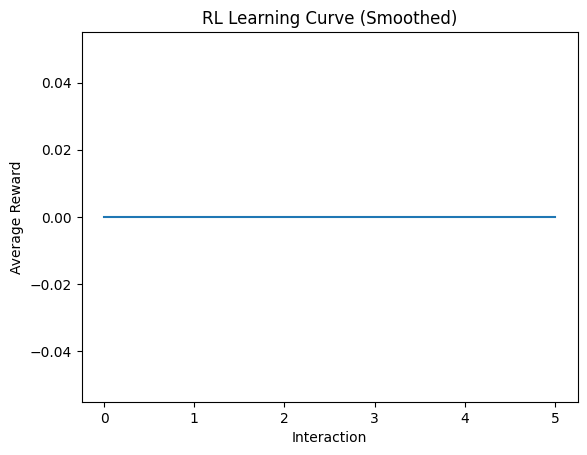

In [188]:
import matplotlib.pyplot as plt
import numpy as np

window = 10
smoothed_rewards = np.convolve(
    reward_history, np.ones(window)/window, mode="valid"
)

plt.figure()
plt.plot(smoothed_rewards)
plt.xlabel("Interaction")
plt.ylabel("Average Reward")
plt.title("RL Learning Curve (Smoothed)")
plt.show()

# Chatbot core

In [189]:
%%writefile chatbot_core.py
import numpy as np
import pandas as pd
import pickle

# -------------------------
# LOAD DATA
# -------------------------
inflation_df = pd.read_csv("inflation_df.csv")
unemployment_df = pd.read_csv("unemployment_df.csv")

# -------------------------
# LOAD INTENT MODEL
# -------------------------
with open("intent_model.pkl", "rb") as f:
    intent_model = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# -------------------------
# LOAD RL Q-TABLE
# -------------------------
with open("q_table.pkl", "rb") as f:
    Q_table = pickle.load(f)

# -------------------------
# RL HELPERS
# -------------------------
def get_confidence_bin(confidence):
    if confidence < 0.4:
        return 0
    elif confidence < 0.7:
        return 1
    return 2

def choose_action(confidence):
    state = get_confidence_bin(confidence)
    return np.argmax(Q_table[state])

# -------------------------
# INTENT DETECTION
# -------------------------
def detect_intent_with_confidence(text):
    vec = vectorizer.transform([text])
    probs = intent_model.predict_proba(vec)[0]

    intent = intent_model.classes_[np.argmax(probs)]
    confidence = np.max(probs)

    if confidence < 0.4:
        return "UNKNOWN", confidence

    return intent, confidence

# -------------------------
# FACT BUILDERS
# -------------------------
def explain_inflation():
    latest = inflation_df.iloc[-1]["inflation_rate"]
    peak = inflation_df["inflation_rate"].max()

    return (
        f"U.S. inflation peaked near {peak:.1f}% and has since eased to around "
        f"{latest:.1f}%, though overall price levels remain elevated."
    )

def explain_unemployment():
    latest = unemployment_df.iloc[-1]["value"]

    return (
        f"The unemployment rate has fallen to around {latest:.1f}%, "
        "reflecting recovery after the pandemic-related job losses."
    )

def explain_comparison():
    return (
        "Inflation and employment are linked through economic cycles. "
        "Falling unemployment can increase demand and push prices higher, "
        "a relationship often described by the Phillips Curve."
    )

def build_facts(intent, question):
    q = question.lower()

    if ("inflation" in q or "prices" in q) and ("jobs" in q or "unemployment" in q):
        return explain_comparison()

    if intent == "INFLATION":
        return explain_inflation()

    if intent == "UNEMPLOYMENT":
        if "covid" in q or "spike" in q:
            return (
                "Unemployment spiked during COVID due to lockdowns, "
                "business closures, and a collapse in economic activity."
            )
        return explain_unemployment()

    return "Limited economic context is available."

# -------------------------
# LLM RESPONSE
# -------------------------
def generate_llm_response(question, facts):
    return facts

Overwriting chatbot_core.py


In [190]:
inflation_df.to_csv("inflation_df.csv", index=False)
unemployment_df.to_csv("unemployment_df.csv", index=False)

with open("intent_model.pkl", "wb") as f:
    pickle.dump(intent_model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [191]:
%%writefile app.py
import streamlit as st
from chatbot_core import (
    detect_intent_with_confidence,
    get_confidence_bin,
    choose_action,
    build_facts,
    generate_llm_response
)

st.set_page_config(page_title="BLS Labor Market Chatbot")

st.title("📊 BLS Labor Market Chatbot")
st.write("Ask about U.S. inflation and unemployment trends (BLS data).")

if "chat_history" not in st.session_state:
    st.session_state.chat_history = []

user_input = st.text_input("Ask a question:")

if user_input:
    intent, confidence = detect_intent_with_confidence(user_input)
    action = choose_action(confidence)

    if intent == "UNKNOWN" or confidence < 0.35:
        response = (
            "I don’t have enough confidence to answer that precisely, "
            "but I can explain inflation or unemployment trends."
        )
    else:
        facts = build_facts(intent, user_input)
        response = generate_llm_response(user_input, facts)

    st.session_state.chat_history.append(("You", user_input))
    st.session_state.chat_history.append(("Chatbot", response))
    st.session_state.chat_history.append(
        ("Confidence", f"{confidence*100:.1f}%")
    )

for speaker, message in st.session_state.chat_history:
    if speaker == "You":
        st.markdown(f"**You:** {message}")
    elif speaker == "Chatbot":
        st.markdown(f"**Chatbot:** {message}")
    else:
        st.caption(f"Confidence: {message}")

Overwriting app.py


In [192]:
!streamlit run app.py &>/content/logs.txt &
!./cloudflared-linux-amd64 tunnel --url http://localhost:8501

2026-02-03T04:45:44Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2026-02-03T04:45:44Z INF Requesting new quick Tunnel on trycloudflare.com...
2026-02-03T04:45:47Z INF +--------------------------------------------------------------------------------------------+
2026-02-03T04:45:47Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2026-02-03T04:45:47Z INF |  https://knock-mold-pipeline-watson.trycloudflare.com 